# Word Embedding for the Harry Potter Series

By: Vinay Chitepu

## Introduction : What is Word Embedding?

Word embedding is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. Loosely speaking, they are vector representations of a particular word. Having said this, what follows is how do we generate them? More importantly, how do they capture the context?

## Import Modules and Setup

#### Import Libraries

In [50]:
import re                                 # Regular Expression
import nltk                               # Natural Language Toolkit
import codecs                             # Word Encoding
import numpy as np                        # Math
import pandas as pd                       # Data Analytics/Data Frames
import seaborn as sns                     # Visualization
import multiprocessing                    # Parallel rocessing
import sklearn.manifold                   # Dimensionality reduction
import gensim.models as w2v               # Word to Vector Model
import matplotlib.pyplot as plt           # Plotting



# Ignores DeprecationWarnings
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# For python2 only
# from __future__ import absolute_import, division, print_function


#### Style Preferences for Visualization

In [2]:
sns.set(style = 'darkgrid', color_codes = True)

def setplt(x=15, y=7):
    f, ax = plt.subplots(1,1,figsize=(x, y))
    sns.despine(f, left=True, bottom=True)

## Importing Data

This example uses the Harry Potter Books that I have compiled into one txt file.

In [6]:
filename = 'HarryPotterSeries.txt'
book_file = codecs.open(filename, 'r', 'utf-8')
file = book_file.read()

print(file[:500]) # file is now our raw_corpus (needs to be tokenized and cleaned)

Harry Potter and the Sorcerer's Stone 

CHAPTER ONE 

THE BOY WHO LIVED 

Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense. 

Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large musta


## Tokenize and Format with NLTK
Our final formatted  and tokenized corpus needs to be a list of wordlists (wordlist = list of words)

#### Downloading NLTK modules needed

In [8]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/VinayR/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/VinayR/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Creating the tokenizer

In [9]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

#### Tokenizing the  raw corpus into a list of sentences

In [10]:
raw_sentences = tokenizer.tokenize(file)

In [13]:
raw_sentences[:5]

["Harry Potter and the Sorcerer's Stone \n\nCHAPTER ONE \n\nTHE BOY WHO LIVED \n\nMr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much.",
 "They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense.",
 'Mr. Dursley was the director of a firm called Grunnings, which made drills.',
 'He was a big, beefy man with hardly any neck, although he did have a very large mustache.',
 'Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors.']

#### Formatting the corpus


In [21]:
# This takes out any weird shit
corpus = [re.sub(r"[^a-zA-Z' ]"," ", a) for a in raw_sentences]

#### Tokenizing the sentences into a list of words

In [25]:
tok_corpus = [nltk.word_tokenize(x) for x in corpus]

In [27]:
len(tok_corpus)

85781

## Word2Vec
Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google. 

Word2vec is a two-layer neural net that processes text. Its input is a text corpus and its output is a set of vectors: feature vectors for words in that corpus. The neural networks are known as 'Skip Gram' and 'Common Bag Of Words' (CBOW). It first constructs a vocabulary from the training text data and then learns vector representation of words. 

Word2vec is similar to an autoencoder, encoding each word in a vector, but rather than training against the input words through reconstruction, it trains words against other words that neighbor them in the input corpus.

Remember a vector has a direction and a magnitude. This can extrapolate past any amount of dimentions we can percieve. The idea is that we should be able to take <code>vector('Paris') - vector('France') + vector('Italy') = vector('Rome')</code>  in a perfect word that is. Likely it will be somewhere near it.

Now some important concepts

### Artificial Neural Networks

#### Introduction
Artificial neural networks, or ANNs, are a family of computational models inspired by the brain which are used to approximate highly complex functions. A single neural network is composed of many highly interconnected processing elements (the nodes aka neurons) which each perform some basic computation on their inputs. Each neuron typically receives many inputs from other neurons in the network, and outputs a nonlinear function of the sum of its weighted inputs. The output from this neuron is then passed through the network as input to the next set of neurons.

The simplest non-linear neural network is the FeedForward Neural network. Also known as the Multilayer Perceptron (MLP)

Example: https://www.youtube.com/watch?v=fQ376G-Ek1E

This animation shows a feedforward neural network. 

Here are some other links to explain this concept better:

Article: https://ujjwalkarn.me/2016/08/09/quick-intro-neural-networks/

Video Series: https://www.youtube.com/watch?v=aircAruvnKk&t=

A strong understaning of neural networks in not necessary for this since the ones we are going to use have already been implemented for us. Here is brief explanation of the two that are important for Word2Vec


####  Common Bag of Words (CBOW)
This method takes the context of each word as the input and tries to predict the word corresponding to the context.

<img src="cbow.png" width="400">

Notice the input os CxV dimensions. C = the amount of context words in the built vocabulary; V = vector dimentions (Explained later)

#### Skip-Gram Model
This looks like multiple-context CBOW model just got flipped. To some extent that is true. We input the target word into the network. The model outputs C probability distributions. What does this mean? For each context position, we get C probability distributions of V probabilities, one for each word.

<img src="skip.png" width="400">

#### Which to pick?
CBOW is faster and represent frequent words pretty well. Skip Gram works well with small amounts of data and can pick up on rare words. It still works well with large data as well though making it the optimal choice.

### Cosine Similarity
So how do we make these relationships? Remember each work is 'encoded' into a vector. What cosine similarity does is find the cosine of the angle between the two vectors. This returns a value between 0 and 1. A value closer to 1 (angle closer to 0 hint hint) means that they are more in context with one another. Here is the formula for this.

<img src="cos.png" width="400">

Note: Since we can use any number of dimensions this can be hard to visualize

Finally lets get back to the coding

### Creating our model

In [72]:
harry2vec = w2v.Word2Vec(
    tok_corpus,                             # input the tokenized for vocab to be built and trained
    sg = 1,                                 # 0(default)=CBOW; 1=Skip-Gram
    seed = 1,                               # Seed for the RNG to make results reproducable
    workers = multiprocessing.cpu_count(),  # number of threads to run in parallel
    size = 100,                             # Dimensionality. Higher=More Training but more generalized
    min_count = 2,                          # minimum word count threshold. Normally 2 or 3
    window = 11,                            # Word context window
    sample=1e-3                             # Downsizing for repeated words
)

#### Look at how big the vocabulary is

In [73]:
len(harry2vec.wv.vocab)

16905

#### Testing it out

In [74]:
# This inputs a words and outputs a list of words paired with their cosine similarities
harry2vec.wv.most_similar('Dumbledore', topn=20)

[('Slughorn', 0.6985189914703369),
 ('headmaster', 0.6922357678413391),
 ('Scrimgeour', 0.6890897750854492),
 ('Lupin', 0.6825191974639893),
 ('Riddle', 0.6771975755691528),
 ('Fudge', 0.6766769886016846),
 ('Dippet', 0.6673427820205688),
 ('Quirrell', 0.65428626537323),
 ('Firenze', 0.6504946947097778),
 ('Voldemort', 0.6402391195297241),
 ('grave', 0.6394936442375183),
 ('flee', 0.6374369859695435),
 ('Snape', 0.6354514956474304),
 ('Cornelius', 0.6353582143783569),
 ('Wormtail', 0.6353499889373779),
 ('Dumbledores', 0.6278672814369202),
 ('foolish', 0.626919150352478),
 ('Karkaroff', 0.6257171630859375),
 ('Aberforth', 0.6222015619277954),
 ('Ariana', 0.6143150329589844)]

Looks like this has decided that Dumbledore goes best in context with other characters (mostly professors)

In [82]:
harry2vec.wv.most_similar('Hogwarts', topn=20)

[('school', 0.7727782726287842),
 ('School', 0.680961012840271),
 ('home', 0.6744586229324341),
 ('Witchcraft', 0.6738272905349731),
 ('secret', 0.6608787775039673),
 ('regular', 0.6598265767097473),
 ('gamekeeper', 0.6565799713134766),
 ('Gringotts', 0.6555415391921997),
 ('inspect', 0.6502987146377563),
 ('Albania', 0.6500905156135559),
 ('Wizardry', 0.6496773362159729),
 ('forever', 0.6489121913909912),
 ('Tournament', 0.6487472057342529),
 ('Durmstrang', 0.6487283706665039),
 ('Houses', 0.6467455625534058),
 ('banned', 0.6465336084365845),
 ('headquarters', 0.6465016603469849),
 ('Express', 0.6464957594871521),
 ('founders', 0.646464467048645),
 ('Last', 0.6462323665618896)]

Looks like this has decided that Hogwarts goes best in context with other locations and also events that happen at the school

In [93]:
# Testing more complex relationships
harry2vec.wv.most_similar_cosmul(positive = ['Malfoy', 'Gryffindor'], negative=['Harry'])

[('Slytherin', 0.9852379560470581),
 ('Ravenclaw', 0.914558470249176),
 ('Slytherins', 0.8996871113777161),
 ('team', 0.876717209815979),
 ('Flint', 0.8668001890182495),
 ('possession', 0.866428554058075),
 ('points', 0.8645671606063843),
 ('Captain', 0.8577068448066711),
 ('Hufflepuff', 0.8577033281326294),
 ('Seeker', 0.8460209369659424)]

Harry is to Gryffindor as Malfoy is to [  ]

## Visualizing Word Embeddings in 2D

This seems like a good model that is making sensible connections. However we are operating in 100 dimensions so we can't really see what is doing on. However there is a solution for this in sklearn called TSNE. It is also available in PyTorch as well.

###  T-Distributed Stochastic Neighbor Embedding (TSNE)
A machine learning algorithm for visualization. Non-linear dimentional reduction to bring high-dimentional data down 2 or 3 dimentions in order to allow for visualization.

#### Creating classifier from sklearn

In [94]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0) # n_components = dimensions

#### Creating large martix of all the words

In [95]:
all_words_vector_matrix = harry2vec.wv.syn0

#### Converting to 2D and training model

Be patient this takes a while (around 10 min). PyTorch's Multicore-TSNE might be a little faster

Link : https://github.com/DmitryUlyanov/Multicore-TSNE

In [ ]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_words_vector_matrix)

In [97]:
all_word_vectors_matrix_2d

array([[-15.052893 ,   0.4063131],
       [ -6.5175047,  41.45885  ],
       [-15.88668  ,  -5.145407 ],
       ...,
       [ 14.30493  , -28.602293 ],
       [ 42.390724 , -31.485195 ],
       [ 41.45155  , -45.84517  ]], dtype=float32)

### Creating a DataFrame for words and their 2D coordinate

In [101]:
harry_pts = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[harry2vec.wv.vocab[word].index])
            for word in harry2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [102]:
harry_pts.head()

,word,x,y
0,Harry,-36.312199,26.083279
1,Potter,11.945925,56.872078
2,and,-15.886680,-5.145407
3,the,-15.052893,0.406313
4,Sorcerer,16.886299,54.104015


### Plotting all words

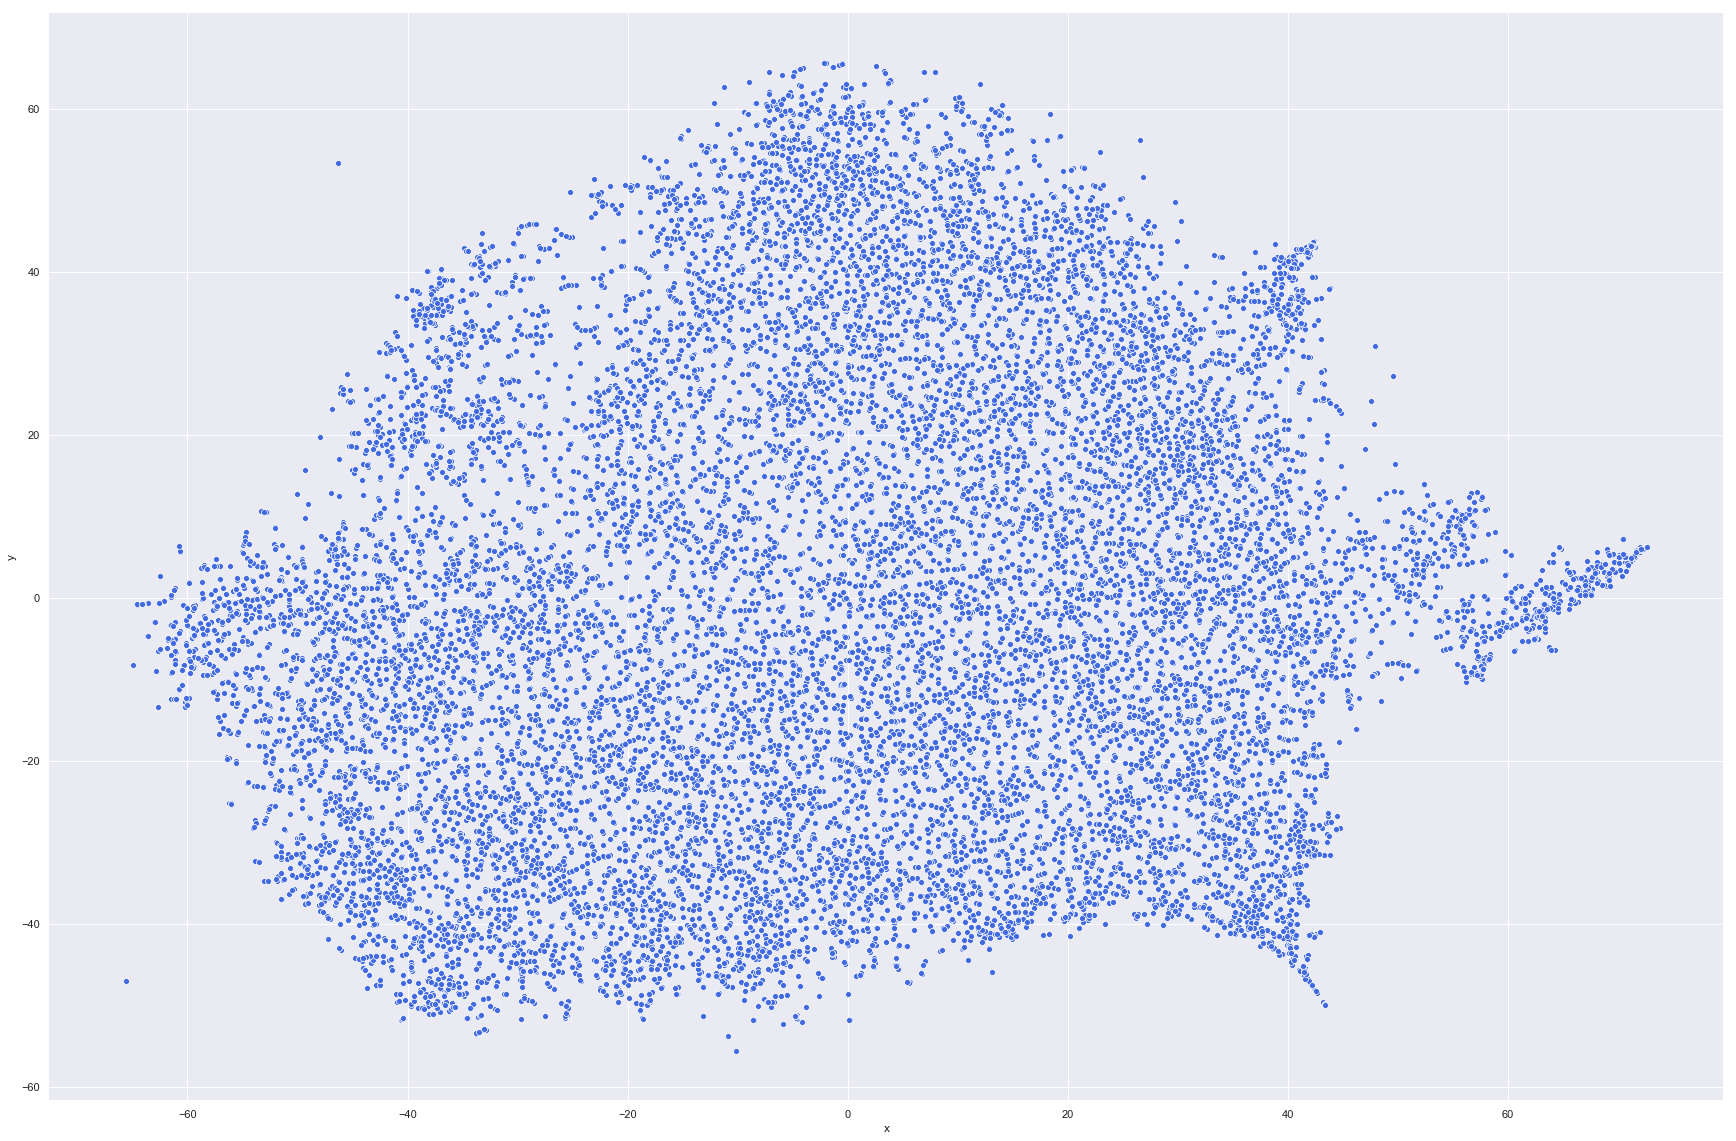

In [111]:
setplt(30,20) # This is the setup function from the 1st block
pl = sns.scatterplot(x = 'x', y = 'y', data = harry_pts, color = 'royalblue')

This is cool to look at but doesn't really help us too much

### Plotting specific regions

#### Function for zooming into a region

In [128]:
def plot_region(x_bounds, y_bounds):
    slice = harry_pts[
        (x_bounds[0] <= harry_pts.x) &
        (harry_pts.x <= x_bounds[1]) & 
        (y_bounds[0] <= harry_pts.y) &
        (harry_pts.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(20, 16))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=15)

#### Function for visualizing and finding similarities for given word

In [129]:
def search_word(word):
    search = harry_pts[harry_pts['word'] == word]
    x1 = float(search['x'] - 2.5); x2 = float(search['x'] + 2.5)
    y1 = float(search['y'] - 2.5); y2 = float(search['y'] + 2.5)
    print(type(x1))
    plot_region((x1,x2), (y1,y2))

## Final Overview

<class 'float'>


[('basilisk', 0.7574330568313599),
 ('Dementor', 0.7422606945037842),
 ('skull', 0.7399563193321228),
 ('Nagini', 0.7263239026069641),
 ('locket', 0.7253718972206116),
 ('spider', 0.7185609936714172),
 ('serpent', 0.7117812633514404),
 ('hood', 0.710774302482605),
 ('rebounded', 0.7060645222663879),
 ('body', 0.7029736638069153)]

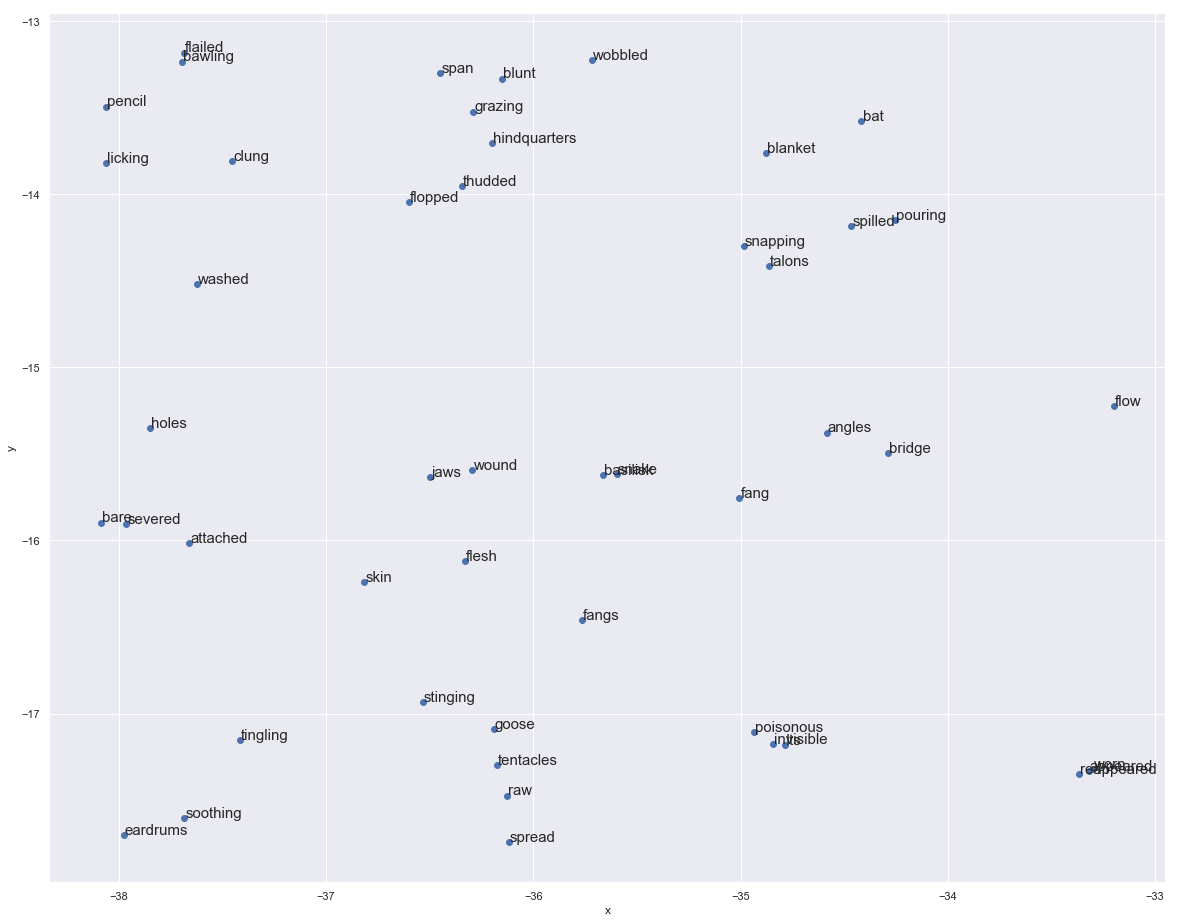

In [151]:
search = 'snake' # Input word to search here
search_word(search)
harry2vec.most_similar(search)

Now we can visualize how this vector kind of looks like and have a working model that can help us create contexts and relationships in the world of Harry Potter.

### Useful references

Here are some extra links for more details on the topic:

https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa

https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

https://skymind.ai/wiki/word2vec